In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
orientation = ["LEADING", "LAGGING"]

In [3]:
# Population-level constants
genome_size = 10_000
gene_length = 100
intergene = 900
interaction_dist = 2500

In [4]:
class Gene:
    def __init__(self, length, orientation, basal_expression, intergene):
        self.length = length                      # Length of the coding sequence                  
        self.intergene = intergene                # Distance to the next gene
        self.orientation = orientation            # Leading or lagging strand
        self.basal_expression = basal_expression  # Initial expression level
        
    def __repr__(self):
        return f'{self.length}, {self.intergene}, {orientation[self.orientation]}, {self.basal_expression}'

In [19]:
class Individual:
    def __init__(self, genes, interaction_dist, nb_eval_steps):
        self.genes = genes
        self.nb_genes = len(genes)
        self.interaction_dist = interaction_dist
        self.nb_eval_steps = nb_eval_steps

        
    def compute_gene_positions(self):
        positions = np.zeros(self.nb_genes, dtype=int)
        cur_pos = 0

        for i_gene, gene in enumerate(self.genes):
            positions[i_gene] = cur_pos
            cur_pos += gene.length + gene.intergene
        
        return positions, cur_pos

        
    def compute_interaction(self, i_1, i_2):
        # Calcul de l'influence de la transcription du gène 2 sur le gène 1    

        if i_1 == i_2: # It's the same gene
            return 1.0


        pos_1 = self.gene_positions[i_1]
        pos_2 = self.gene_positions[i_2]

        ## On veut savoir si le gène 1 est avant le gène 2 ou après
        # Avant : -------1--2-------- ou -2---------------1-
        # Après : -------2--1-------- ou -1---------------2-

        if pos_1 < pos_2: # -------1--2-------- ou -1---------------2-
            if pos_2 - pos_1 < self.genome_size + pos_1 - pos_2: # -------1--2--------
                distance = pos_2 - pos_1
                is_before = True
            else: # -1---------------2-
                distance = self.genome_size + pos_1 - pos_2
                is_before = False

        else: # -------2--1-------- ou -2---------------1-
            if pos_1 - pos_2 < self.genome_size + pos_2 - pos_1: # -------2--1--------
                distance = pos_1 - pos_2
                is_before = False
            else:
                distance = self.genome_size + pos_2 - pos_1
                is_before = True

        ## Orientations relatives
        if ((is_before and self.genes[i_2].orientation == 0) or
            (not is_before and self.genes[i_2].orientation == 1)):
            sign = +1
        else:
            sign = -1

        strength = max(1 - distance/interaction_dist, 0)

        return sign * strength

    
    def compute_inter_matrix(self):
        inter_matrix = np.zeros((self.nb_genes, self.nb_genes))

        for i in range(self.nb_genes):
            for j in range(self.nb_genes):
                inter_matrix[i, j] = self.compute_interaction(i, j)
                
        return inter_matrix


    def run_system(self, nb_steps):
        temporal_expr = np.zeros((self.nb_genes, nb_steps))

        # Initial values at t = 0
        temporal_expr[:, 0] = np.array([gene.basal_expression for gene in self.genes])

        # Iterate the system
        for t in range(1, nb_steps):
            temporal_expr[:, t] = self.inter_matrix @ temporal_expr[:, t-1]
            temporal_expr[:, t] = np.maximum(temporal_expr[:, t], 0)
            temporal_expr[:, t] = np.minimum(temporal_expr[:, t], 2)

        return temporal_expr

    
    def compute_fitness(self, expr_levels):
        # On renvoie la somme des valeurs moyennes d'expression sur les 5 derniers pas de temps 
        avg_steps = 5
        nb_genes, nb_steps = expr_levels.shape
        return np.mean(expr_levels[:, nb_steps-avg_steps:])
    
    
    def evaluate(self): # À changer si on évalue un individu plusieurs fois
        self.gene_positions, self.genome_size = self.compute_gene_positions()
        self.inter_matrix = self.compute_inter_matrix()
        
        self.expr_levels = self.run_system(self.nb_eval_steps)
        self.fitness = self.compute_fitness(self.expr_levels)
        
        return self.expr_levels, self.fitness
        

In [14]:
def generate_genes(nb_genes, gene_length, intergene):
    genes = []

    for gene in range(nb_genes):
        new_gene = Gene(length=gene_length,
                        intergene=intergene,
                        orientation=np.random.randint(2),
                        basal_expression=np.random.random()) 
        genes.append(new_gene)

    return genes

In [15]:
def plot_expr(temporal_expr, fitness, plot_name):
    nb_genes, nb_steps = temporal_expr.shape
    
    #colormap = mpl.cm.get_cmap('viridis', nb_genes)(range(nb_genes))
    
    plt.figure(figsize=(9, 6), dpi=200)
    
    for gene in range(nb_genes):
        linestyle = 'solid' if genes[gene].orientation == 0 else 'dashed'
        plt.plot(temporal_expr[gene, :],
                 linestyle=linestyle,
                 #color=colormap[gene],
                 label=f'Gene {gene}')
    
    plt.grid(linestyle=':')
    plt.xlabel('Time', fontsize='large')
    plt.ylabel('Expression level', fontsize='large')
    
    plt.legend(loc='center right')
    plt.title(f'Fitness: {fitness:.2}')
        
    plt.savefig(plot_name, dpi=300, bbox_inches='tight')

In [24]:
genes = generate_genes(nb_genes=10, gene_length=gene_length, intergene=intergene)

In [25]:
indiv = Individual(genes=genes, interaction_dist=interaction_dist, nb_eval_steps=16)

In [26]:
res, fitness = indiv.evaluate()

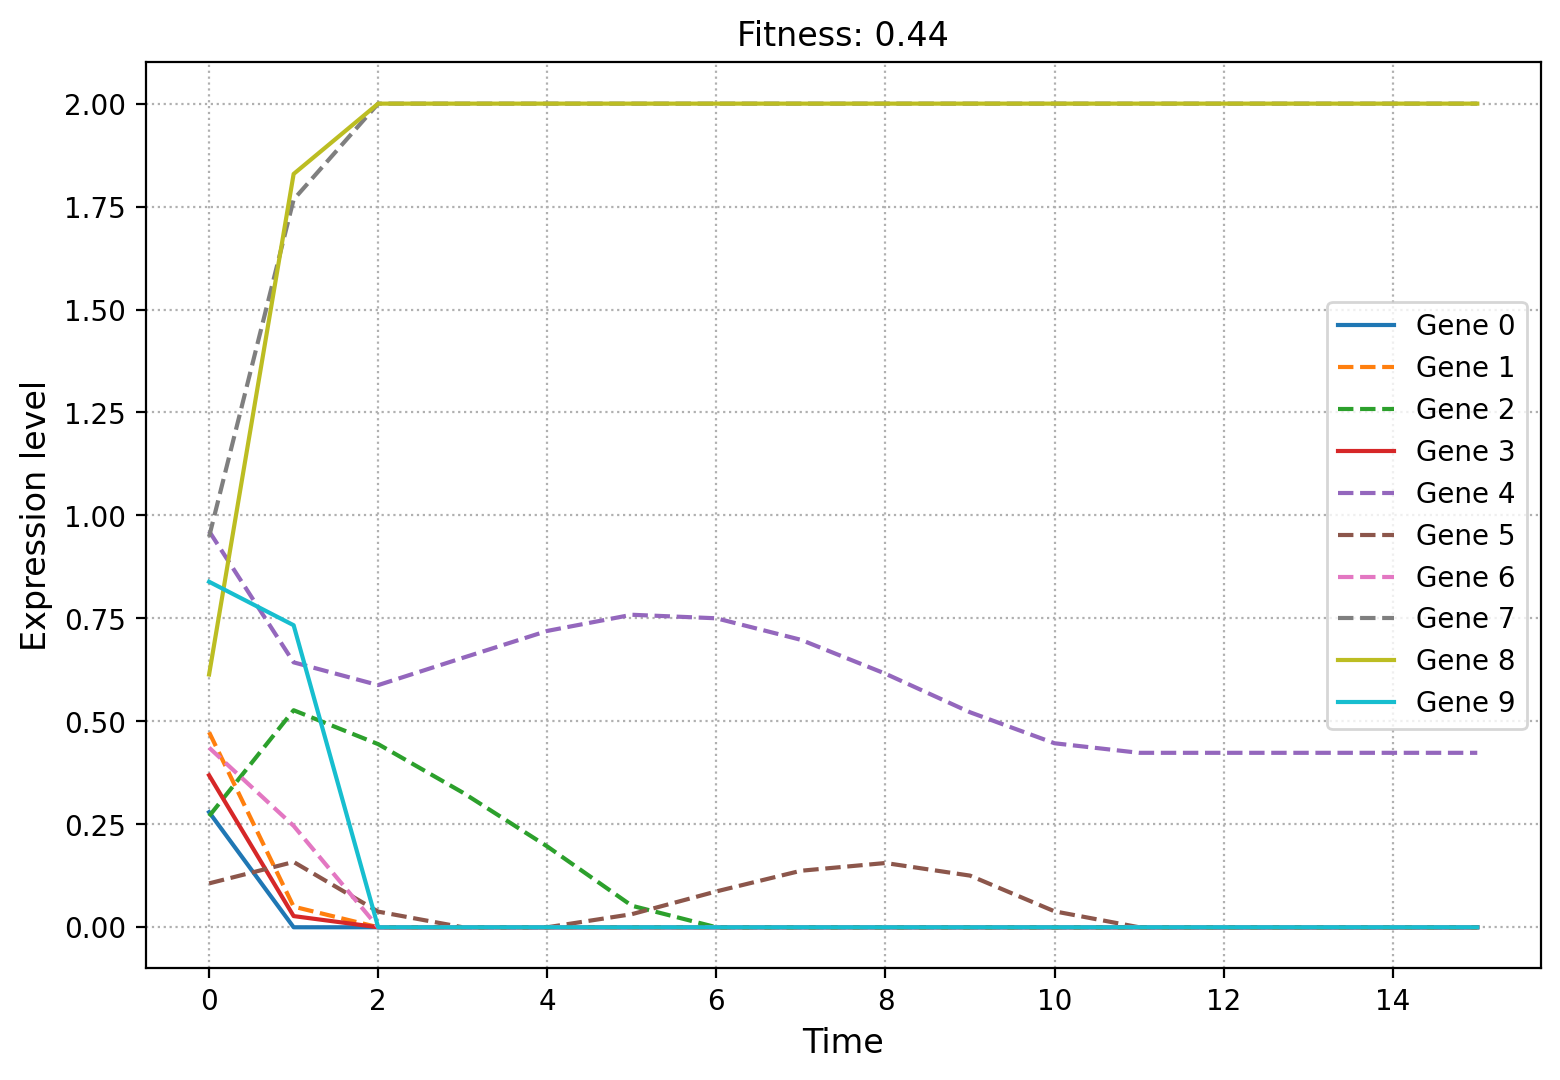

In [27]:
plot_expr(res, fitness, 'baseline')

In [ ]:
for i_switched_gene in range(len(genes)):
    # Switch the current gene 
    to_switch = indiv.genes[i_switched_gene]
    to_switch.orientation = 1 - to_switch.orientation
    
    # Run the switched system and plot
    switch_res, switch_fit = run_individual(genes, 16)
    print(f'Switched gene {i_switched_gene}, fitness: {switch_fit}')
    plot_expr(switch_res, switch_fit, f'switched_{i_switched_gene}')
    
    # Reset the gene to its former orientation
    to_switch.orientation = 1 - to_switch.orientation